#### Imports

In [1]:
import numpy as np
import pandas as pd

In [2]:
from razdel import sentenize

In [3]:
import random

In [4]:
from tqdm import tqdm

In [5]:
import re
import os

#### User-defined

In [6]:
from processing import REMAIN_PUNCT, END_PUNC, PUNCT_TO_TOKEN
from processing import process_raw_sentence, tokenize

#### Visualisation

In [7]:
import matplotlib
import matplotlib.pyplot as plt

In [8]:
import scienceplots

plt.style.use('science')
%config InlineBackend.figure_format = 'retina'

lables_fs = 16
ticks_fs = 12

## All downloaded books by Pushkin

In [9]:
pushkin_raw_dir = '../data/raw/pushkin'

In [10]:
books = []

for file in os.listdir(pushkin_raw_dir):  # through files in selected directory            
    filename = os.fsdecode(file)
    if filename.endswith(".txt"):  # looking for .txt files in the directory
        books.append(filename)

print(*books, sep='\n')

dubrovsky.txt
povesti_belkina.txt
kapitanskaya_dochka.txt
pugachevs_story.txt


In [11]:
# select book
book_filename = books[0]
book_filename

'dubrovsky.txt'

In [12]:
with open(os.path.join(pushkin_raw_dir, book_filename), 'r') as file:
    book_raw = file.read()

### Splitting by chapters

In [13]:
# also chapters can be detected by their length!
chapter_length_th = 1000  # chapter length threshold

chapter_num = 1
for prt in re.split('\n\n', book_raw):
    if len(prt) > chapter_length_th:
        print(f'{len(prt)}\t<- Chapter {chapter_num}')
        chapter_num += 1
    else:
        print(len(prt))

39
15
9
14047	<- Chapter 1
9
12206	<- Chapter 2
10
8960	<- Chapter 3
9
4296	<- Chapter 4
8
8610	<- Chapter 5
9
6952	<- Chapter 6
10
2986	<- Chapter 7
11
7804	<- Chapter 8
14
10
13040	<- Chapter 9
8
4882	<- Chapter 10
9
9113	<- Chapter 11
10
8401	<- Chapter 12
11
6676	<- Chapter 13
10
2170	<- Chapter 14
9
3130	<- Chapter 15
10
4368	<- Chapter 16
11
8813	<- Chapter 17
11
4311	<- Chapter 18
10
5240	<- Chapter 19


In [14]:
chapters_list = []  # list with chapters text (with replaced '\n' by ' ')

for text_part in re.split('\n\n', book_raw):  # includes paragraphs with chapter's numbers and epigraphs
    if len(text_part) > chapter_length_th:
        text_part = text_part.replace('\n', ' ')
        text_part = re.sub('[\[].*?[\]]', '', text_part)
        chapters_list.append(text_part)  # add chapter text without '\n'

In [15]:
print(f'Number of chapters: {len(chapters_list)}')

Number of chapters: 19


### Splitting by sentences

Let's try to use [`razdel`](https://github.com/natasha/razdel) to atomize chapters by sentences. It seems really good solution!

In [16]:
num_sentences_by_chapters = []

for chapter_number in range(len(chapters_list)):
    num_sentences_by_chapters.append(len(list(sentenize(chapters_list[chapter_number]))))
    print(f'Chapter {chapter_number + 1}:\t {num_sentences_by_chapters[-1]}')

print(f'\nTotal number of sentences: {sum(num_sentences_by_chapters)}')

Chapter 1:	 117
Chapter 2:	 49
Chapter 3:	 82
Chapter 4:	 47
Chapter 5:	 105
Chapter 6:	 98
Chapter 7:	 25
Chapter 8:	 59
Chapter 9:	 150
Chapter 10:	 53
Chapter 11:	 107
Chapter 12:	 101
Chapter 13:	 64
Chapter 14:	 27
Chapter 15:	 38
Chapter 16:	 43
Chapter 17:	 113
Chapter 18:	 47
Chapter 19:	 50

Total number of sentences: 1375


### Sentence cleaning

We will restrict our model to prediction of `,` (commas) within a sentence and `!` (exclamation point), `?` (question mark) and `.` (periods) in the end of a sentence.

Hence a **processing of other punctuation** is as following:
1. substitute of `:` (colon) or `;` (semicolon) by `,` (comma);
2. substitute of `!` and `?` in the middle of a sentence by `,` (comma);
3. substitute of `—` (dash) by `,` (comma) in the middle of a sentence;
4. delete `—` in the beginning of a sentence;
5. delete all `"'«»` (quotes).

Additional symbols:
1. there is some info in periods `()` in the book text - delete it (or leave if it is a complete sentence);
2. all `*` must be deleted.

In [17]:
%%time

all_sentences_raw = []
all_sentences_processed = []
all_sentences_lengths = []

for chapter_number in range(len(chapters_list)):
    for substring in sentenize(chapters_list[chapter_number]):
        sentence = substring.text
        
        if len(sentence) > 5 and not bool(re.search('[a-zA-Z]', sentence)):
            # delete too short sentences and sentences with non-russian letters
            all_sentences_raw.append(sentence)
            
            processed_sentence = process_raw_sentence(sentence)  # process sentence
            len_processed = len(processed_sentence.split(' '))  # find length of the sentence
            all_sentences_processed.append(processed_sentence)
            all_sentences_lengths.append(len_processed)

CPU times: user 53.5 ms, sys: 2.07 ms, total: 55.6 ms
Wall time: 55.7 ms


#### DataFrame with sentences

In [18]:
book_sent_df = pd.DataFrame()

book_sent_df['raw'] = all_sentences_raw
book_sent_df['processed'] = all_sentences_processed
book_sent_df['len'] = all_sentences_lengths

In [19]:
book_sent_df.shape

(1363, 3)

In [20]:
pd.options.display.max_colwidth = 200
book_sent_df.sample(5)

,raw,processed,len
1317,"Караульщик кончил свою работу, встряхнул свою рухлядь, полюбовался заплатою, приколол к рукаву иголку – сел на пушку верхом и запел во все горло меланхолическую старую песню: Не шуми, мати зеленая...","караульщик кончил свою работу, встряхнул свою рухлядь, полюбовался заплатою, приколол к рукаву иголку, сел на пушку верхом и запел во все горло меланхолическую старую песню, не шуми, мати зеленая ...",36
286,"Лицо его стало мрачнее ночи, он с презрением улыбнулся, грозно взглянул на дворню и поехал шагом около двора.","лицо его стало мрачнее ночи, он с презрением улыбнулся, грозно взглянул на дворню и поехал шагом около двора.",18
1115,"Он о любви не хлопотал, довольный ее безмолвным согласием.","он о любви не хлопотал, довольный ее безмолвным согласием.",9
1172,"– Тебе како дело? – отвечал мальчишка, стараясь от него освободиться.","тебе како дело, отвечал мальчишка, стараясь от него освободиться.",9
3,"Кирила Петрович принимал знаки подобострастия как надлежащую дань; дом его всегда был полон гостями, готовыми тешить его барскую праздность, разделяя шумные, а иногда и буйные его увеселения.","кирила петрович принимал знаки подобострастия как надлежащую дань, дом его всегда был полон гостями, готовыми тешить его барскую праздность, разделяя шумные, а иногда и буйные его увеселения.",27


#### Sentences length statistics

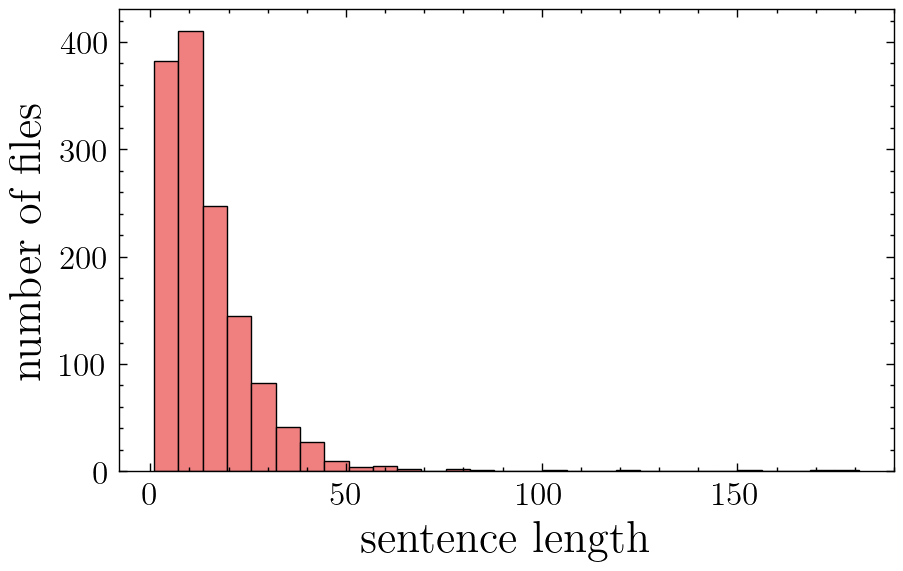

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))

pd.DataFrame.hist(
    data=book_sent_df,
    column='len',
    ax=ax,
    bins=29,
    legend=False,
    color='lightcoral',
    alpha=1,
    edgecolor='k',
    lw=0.5,
)

ax.set_title(book_filename, fontsize=lables_fs)

ax.tick_params(axis='both', which='major', labelsize=ticks_fs)

plt.title(None)
plt.xlabel('sentence length', fontsize=lables_fs)
plt.ylabel('number of files', fontsize=lables_fs)

ax.grid(False)
plt.show()
# fig.savefig(f'figures/name.eps', format='eps')

### Prepare all sentences and targets for further prediction

In [22]:
all_inputs = []
all_targets = []

for ind_row in tqdm(range(book_sent_df.shape[0])):
    sentence_this = book_sent_df.iloc[ind_row]['processed']

    input_this = sentence_this
    for mark in REMAIN_PUNCT:
        input_this = input_this.replace(mark, '')

    target_this = tokenize(sentence_this)

    assert len(target_this.split(' ')) == len(input_this.split(' '))
    
    all_inputs.append(input_this)
    all_targets.append(target_this)

100%|████████████████████████████████████| 1363/1363 [00:00<00:00, 25452.39it/s]


In [23]:
# add new rows to DF
book_sent_df['input'] = all_inputs
book_sent_df['target'] = all_targets

### Saving prepared data

In [24]:
book_sent_df.sample(10)

,raw,processed,len,input,target
997,"Князь прихрамывал, устав от своей прогулки, и уже раскаиваясь в своем посещении.","князь прихрамывал, устав от своей прогулки, и уже раскаиваясь в своем посещении.",12,князь прихрамывал устав от своей прогулки и уже раскаиваясь в своем посещении,S C S S S C S S S S S P
358,"Владимир смотрел на них, и странные чувства волновали его.","владимир смотрел на них, и странные чувства волновали его.",9,владимир смотрел на них и странные чувства волновали его,S S S C S S S S P
710,"Этот был не промах, не разиня.","этот был не промах, не разиня.",6,этот был не промах не разиня,S S S C S P
605,– Это кто? – спросил хозяин.,"это кто, спросил хозяин.",4,это кто спросил хозяин,S C S P
616,"– Как за что, батюшка Кирила Петрович? а за тяжбу-то покойника Андрея Гавриловича.","как за что, батюшка кирила петрович, а за тяжбу-то покойника андрея гавриловича.",12,как за что батюшка кирила петрович а за тяжбу-то покойника андрея гавриловича,S S C S S C S S S S S P
1199,"Признавайся во всем, или так отдеру тебя розгою, что ты и своих не узнаешь.","признавайся во всем, или так отдеру тебя розгою, что ты и своих не узнаешь.",14,признавайся во всем или так отдеру тебя розгою что ты и своих не узнаешь,S S C S S S S C S S S S S P
670,– Я отдал ему письмо и деньги.,я отдал ему письмо и деньги.,6,я отдал ему письмо и деньги,S S S S S P
408,Наконец все утихло.,наконец все утихло.,3,наконец все утихло,S S P
908,"– Обстоятельства требуют… я должен вас оставить, – сказал он наконец, – вы скоро, может быть, услышите…","обстоятельства требуют я должен вас оставить, сказал он наконец, вы скоро, может быть, услышите.",14,обстоятельства требуют я должен вас оставить сказал он наконец вы скоро может быть услышите,S S S S S C S S C S C S C P
357,"Умрем, а не выдадим.","умрем, а не выдадим.",4,умрем а не выдадим,C S S P


In [25]:
pushkin_prepared_dir = '../data/prepared/pushkin'
book_filename_csv = book_filename.split('.')[0] + '.csv'

In [26]:
# saving dataframe (only 'input' and 'target' columns)
book_sent_df[['input', 'target']].to_csv(os.path.join(pushkin_prepared_dir, book_filename_csv))